LyricGen is supposed to receive prompts (later features/conditions delivered externally) give back lyrics in the style of my own lyrics. Trained on my texts, lyrics and poems, it should generate in-style lyrics responding to the semantic category of the prompt.

In [2]:
import re
import json
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
from torch.optim import AdamW

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


config = GPT2Config.from_pretrained('gpt2', output_hidden_states=False, output_attentions=False)
config.dropout = 0.1
config.weight_decay = 0.01

model = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

Current model is performing almost as expected. It seems to be slightly over-fitted, therefore I need to clean the data first to see if that's the case. The data used is only being utilized as an example and must go through further detailed examination and categorization.

Epoch: 0, Loss: 1.2863805294036865
Epoch: 1, Loss: 1.0014617443084717
Epoch: 2, Loss: 0.8238615393638611
Epoch: 3, Loss: 0.6729519963264465
Epoch: 4, Loss: 0.48130401968955994
Epoch: 5, Loss: 0.34825339913368225
Epoch: 6, Loss: 0.23439225554466248
Epoch: 7, Loss: 0.12879738211631775
Epoch: 8, Loss: 0.11326070874929428
Epoch: 9, Loss: 0.07961457967758179
Epoch: 10, Loss: 0.04682844877243042


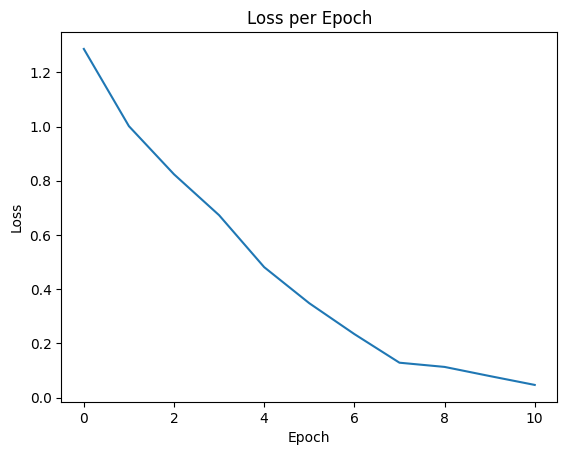

In [3]:

losses = []

with open('semantic-lyrics-pairs.json', 'r') as f:
    data = json.load(f)

lyrics = [' '.join(item['lyrics']) for item in data]

inputs = tokenizer(lyrics, return_tensors='pt', truncation=True, padding=True)
dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'])

dataloader = DataLoader(dataset, batch_size=2)

optimizer = AdamW(model.parameters(), lr=1e-4)

model.train()

for epoch in range (11):
    for batch in dataloader:
        input_ids, attention_mask = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    losses.append(loss.item())
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()

This Should save the trained model.

In [24]:
model_path = './'  


model.save_pretrained(model_path)



tokenizer.save_pretrained(model_path)

print(f"Model and tokenizer saved to {model_path}")


Model and tokenizer saved to ./


The test is performing very poorly.

Theory:
1- Data labeling is horrible (which is)
2- Data quality is very low
3- Adjective diversity is very poor

Solution:
1- Clean Data?
2- More Data?
3- Check if the semantic tag is being recognized

In [25]:

with open('test-lyrics.json', 'r') as f:
    test_data = json.load(f)

test_lyrics = [' '.join(item['lyrics']) for item in test_data]
test_inputs = tokenizer(test_lyrics, return_tensors='pt', truncation=True, padding=True)
test_dataset = torch.utils.data.TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'])

test_dataloader = DataLoader(test_dataset, batch_size=2)

model.eval()
total_test_loss = 0
for batch in test_dataloader:
    with torch.no_grad():
        input_ids, attention_mask = batch
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        total_test_loss += outputs.loss.item()

average_test_loss = total_test_loss / len(test_dataloader)

print(f"Test Loss: {average_test_loss}")

Test Loss: 5.348606765270233


In [28]:
prompt = "Hope"
input_ids = tokenizer.encode(prompt, return_tensors="pt")
attention_mask = torch.ones_like(input_ids)

output = model.generate(
    input_ids,
    max_length=50,
    attention_mask=attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    temperature=2.0
)


generated_text = tokenizer.decode(output[0], skip_special_tokens=True)


generated_text = generated_text[len(prompt):].lstrip()
generated_text = generated_text[0].upper() + generated_text[1:]


formatted_text = re.sub(r'(?<!^)(?<!\n)(?=[A-Z])', '\n', generated_text)

print(formatted_text)

It all 
We come pure and somehow blue 
Let go of all 
That we belong 
With all that we should've taken care of 
And hoped that somehow... 
Nothing will happen 
If we take farthing 
For nothing, forever
